In [1]:
import numpy as np
import pandas as pd
import seaborn as sn

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, scale
from sklearn.model_selection import train_test_split

In [2]:
features = 11
output = 2
np.set_printoptions(precision = 2)
np.set_printoptions(suppress = True)

In [3]:
class MultiLayerNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(features, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),        
        nn.Linear(32, 8),
        nn.ReLU(),
        nn.Linear(8, output),
    )

  def forward(self, x):
    x = self.layers(x)
    return torch.sigmoid(x)

In [4]:
class WineDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
    
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X, Y = self.X[idx], self.Y[idx]
    return X, Y

In [5]:
wine = np.loadtxt("vinhoVermelho.csv", delimiter= ",")
#wine = np.loadtxt("winequality-red.csv", delimiter= ";", skiprows= 1)

X = wine[:,:features]

X = scale(X)

label = wine[:, features:]

oneHot = OneHotEncoder()

label = oneHot.fit_transform(label).toarray()

divisao = 1/3

X_train2 , X_test , Y_train2 , Y_test = train_test_split(X , label, test_size = divisao)

X_train, X_validation, Y_train, Y_validation = train_test_split(X_train2, Y_train2, test_size = divisao)

print(len(X_train))
print(len(X_validation))
print(len(X_test))

710
356
533


In [6]:
train_dataset = WineDataset(X_train, Y_train)
validation_dataset = WineDataset(X_validation, Y_validation)
test_dataset = WineDataset(X_test, Y_test)

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=len(train_dataset), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(train_dataset), shuffle=True)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando {device}")

Rodando cpu


In [8]:
model = MultiLayerNetwork().to(device)

In [9]:
#basicamente essa função de erro vê o numero que a rede deu como resposta
#e se o valor for perto do correto, o erro é muito baixo
#e se o valor for muito distante, o erro é muito alto
#aqui usa a versão binaria
lossfunc = nn.BCELoss()

#SGD calcula o gradiente do menor erro encontrado para atualizar os parametros
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [10]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():  
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

In [11]:
def train(model, dataloader, lossfunc, optimizer):
  model.train()
  cumloss = 0.0

  for X, Y in dataloader:
    
    X = X.unsqueeze(1).float().to(device)
    Y = Y.unsqueeze(1).float().to(device)
    pred = model(X)
    loss = lossfunc(pred, Y)

    #zera os gradientes acumulados
    optimizer.zero_grad()
    #computa os gradientes
    loss.backward()
    #anda na direção que reduz o erro local
    optimizer.step()


    # loss é um tensor para obter valor float
    cumloss += loss.item()

  return cumloss / len(dataloader)

In [12]:
def test(model, dataloader, lossfunc):
  model.eval()
  list_pred = []
  cumloss = 0.0

  with torch.no_grad():
    for X, Y in dataloader:
      X = X.unsqueeze(1).float().to(device)
      Y = Y.unsqueeze(1).float().to(device)
      pred = model(X)
      list_pred.append(pred)
      loss = lossfunc(pred, Y)
      cumloss += loss.item()

  return cumloss / len(dataloader)

Epoch: 0; Train Loss: 0.6987531781196594
Epoch: 10; Train Loss: 0.6965417265892029
Epoch: 20; Train Loss: 0.694983720779419
Epoch: 30; Train Loss: 0.6938664317131042
Epoch: 40; Train Loss: 0.693056583404541
Epoch: 50; Train Loss: 0.692444384098053
Epoch: 60; Train Loss: 0.6919670701026917
Epoch: 70; Train Loss: 0.6915757060050964
Epoch: 80; Train Loss: 0.6912254095077515
Epoch: 90; Train Loss: 0.6908895373344421
Epoch: 100; Train Loss: 0.6905495524406433
Epoch: 110; Train Loss: 0.6901893019676208
Epoch: 120; Train Loss: 0.6897940039634705
Epoch: 130; Train Loss: 0.689349889755249
Epoch: 140; Train Loss: 0.6888417601585388
Epoch: 150; Train Loss: 0.6882523894309998
Epoch: 160; Train Loss: 0.687560498714447
Epoch: 170; Train Loss: 0.6867374181747437
Epoch: 180; Train Loss: 0.6857531070709229
Epoch: 190; Train Loss: 0.684557318687439
Epoch: 200; Train Loss: 0.6831053495407104
Epoch: 210; Train Loss: 0.6813165545463562
Epoch: 220; Train Loss: 0.6791090965270996
Epoch: 230; Train Loss: 0.67

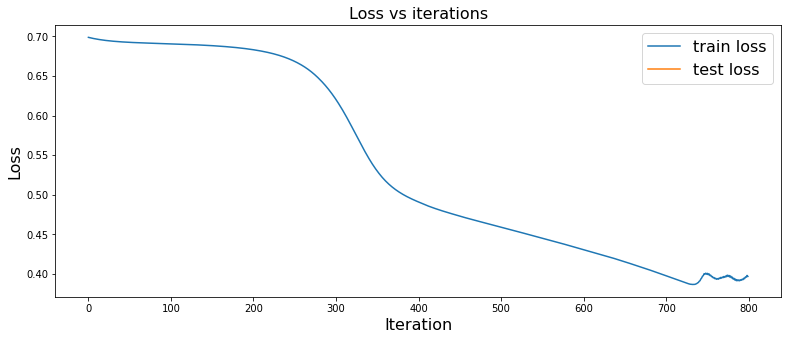

In [13]:
epoch = 800
train_losses = []
validation_losses = []

for t in range(epoch):
  train_loss = train(model, train_dataloader, lossfunc, optimizer)
  if t  % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
  train_losses.append(train_loss)
  #validation_losses.append(test(model, validation_dataloader, lossfunc))
  

#train_losses = {"train loss": train_losses}
#validation_losses = {'validation loss': validation_losses}
#print(f"Test Loss: {validation_losses}")
losses = {"train loss": train_losses, "test loss": validation_losses}
plot_losses(losses)

In [14]:
act_class = []
pred_class = []

X = Variable(torch.from_numpy(X_validation).float())
Y = Variable(torch.from_numpy(Y_validation).float())

train_out = oneHot.inverse_transform(model(X).data.numpy())


print('Training accuracy', accuracy_score(oneHot.inverse_transform(Y), train_out))

test_out=oneHot.inverse_transform(model(torch.from_numpy(X_test).float()).data.numpy())
print('prediction accuracy', accuracy_score(oneHot.inverse_transform(Y_test), test_out))

act_class.append(oneHot.inverse_transform(Y_test))
pred_class.append(test_out)

confusion = confusion_matrix(oneHot.inverse_transform(Y_test), test_out)


Training accuracy 0.7191011235955056
prediction accuracy 0.7523452157598499


[[207  29]
 [103 194]]


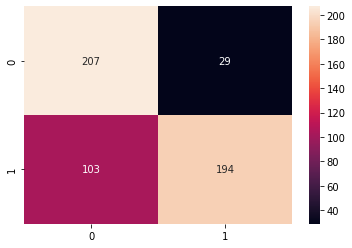

In [15]:


print(confusion)
#sn.set(font_scale=1.4) # for label size
sn.heatmap(confusion, annot=True, fmt="")
#sn.heatmap(confusion, annot=True, annot_kws={"size": 16}) # font size



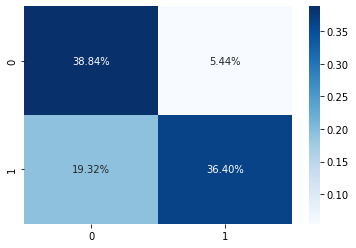

In [16]:
sn.heatmap(confusion/np.sum(confusion), annot=True, 
            fmt='.2%', cmap='Blues')